# PBMCs Tutorial
PBMC stands for Peripheral Blood Mononuclear Cells, a vital group of immune system cells found in the blood

## 0. Initial setup
- Install LINGER according to the [GitHub](https://github.com/Durenlab/LINGER)

In [ ]:
%%bash
# conda create -n LINGER python==3.10.0
# conda activate LINGER
# pip install LingerGRN==1.105
# conda install -c bioconda bedtools  # Requirement

- Register the kernel

In [ ]:
%%bash
# pip install ipykernel
# python -m ipykernel install --user --name LINGER --display-name "Python (LINGER)"

- Verify installation

In [2]:
!pip show LingerGRN

Name: LingerGRN
Version: 1.105
Summary: Gene regulatory network inference
Home-page: https://github.com/Durenlab/LINGER
Author: Kaya Yuan
Author-email: qyyuan33@gmail.com
License: MIT
Location: /opt/conda/envs/LINGER/lib/python3.10/site-packages
Requires: anndata, joblib, matplotlib, numpy, pandas, pybedtools, rpy2, scanpy, scikit-learn, scipy, seaborn, shap, statsmodels, torch, umap-learn
Required-by: 


In [3]:
!conda info --envs


# conda environments:
#
# * -> active
# + -> frozen
base                     /opt/conda
LINGER               *   /opt/conda/envs/LINGER



In [ ]:
!conda list -n LINGER                    # lists all packages in LINGER env

In [ ]:
!conda list -n LINGER LingerGRN          # look for package LingerGRN in LINGER env

- Check ressources

In [5]:
!nproc --all

32


In [6]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:           129Gi        14Gi       108Gi       170Mi       8.0Gi       115Gi
Swap:             0B          0B          0B


In [ ]:
!nvidia-smi

In [13]:
import torch
print(f"GPU: {torch.cuda.get_device_name(0)}") if torch.cuda.is_available() else print("No GPU detected")

GPU: NVIDIA RTX 6000 Ada Generation


## 1. Download the general gene regulatory network
This is the pretrained NN on bulk multiomics data across tissues : RNA-seq (gene expr.) and ATAC-seq (chrom. acc.) that will then be fine tuned with our single cell data. There is one pretrained NN per gene.

### About the bulk GRN

It contains three types of interactions (TF-RE-TG) : 
- TF &rarr; RE : biding strength (&alpha;)
- RE &rarr; TG : cis regulatory strength (&beta;)
- TF &rarr; TG : trans regulatory strength (&gamma;)

We obtain **&alpha;** by extracting the weights from the input layer to the second layer (each TF and RE are connected to the 64 hidden neurons of h1). An embedding of a TF/RE is a vector of weitghs, we can then measure how similar two embeddings are. If a TF and RE have similar learned representations, they are likely to interact and will have a high biding strength.<br><br>
We get **&beta;** and **&gamma;** using the average shapley value (that calculates the contribution of a feature to the prediction) over all cells.

In [7]:
!pwd

/globalsc/users/v/a/vangysel/Linger


In [1]:
%%bash
# Set directories and download general GRN
Datadir=$GLOBALSCRATCH/Linger/LINGER_data                     
mkdir -p $Datadir   
    
# Download general GRN from Google Drive
wget -nv -O $Datadir --load-cookies /tmp/cookies.txt "https://drive.usercontent.google.com/download?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.usercontent.google.com/download?id=1jwRgRHPJrKABOk7wImKONTtUupV7yJ9b'  -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1jwRgRHPJrKABOk7wImKONTtUupV7yJ9b" -O data_bulk.tar.gz
rm -rf /tmp/cookies.txt

2026-02-10 12:28:35 URL:https://drive.usercontent.google.com/download?export=download&confirm=&id=1jwRgRHPJrKABOk7wImKONTtUupV7yJ9b [20812483490/20812483490] -> "data_bulk.tar.gz" [1]


In [ ]:
!tar -xzf data_bulk.tar.gz

## 2. Prepare the input data

- Download the h5 file (the matrix contains both RNA and ATAC data combined)

In [32]:
%%bash
mkdir -p data
wget --progress=bar:force -O data/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5 https://cf.10xgenomics.com/samples/cell-arc/1.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5

--2026-02-04 15:24:27--  https://cf.10xgenomics.com/samples/cell-arc/1.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162282142 (155M) [binary/octet-stream]
Saving to: ‘data/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5’

data/pbmc_granulocy 100%[===================>] 154.76M   109MB/s    in 1.4s    

2026-02-04 15:24:29 (109 MB/s) - ‘data/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5�� saved [162282142/162282142]



- Download cell annotation

In [14]:
%%bash
wget --progress=bar:force -O data --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=17PXkQJr8fk0h90dCkTi3RGPmFNtDqHO_' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=17PXkQJr8fk0h90dCkTi3RGPmFNtDqHO_" -O PBMC_label.txt && rm -rf /tmp/cookies.txt

--2026-02-09 12:35:13--  https://docs.google.com/uc?export=download&confirm=&id=17PXkQJr8fk0h90dCkTi3RGPmFNtDqHO_
Resolving docs.google.com (docs.google.com)... 173.194.76.100, 173.194.76.113, 173.194.76.102, ...
Connecting to docs.google.com (docs.google.com)|173.194.76.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=17PXkQJr8fk0h90dCkTi3RGPmFNtDqHO_&export=download [following]
--2026-02-09 12:35:13--  https://drive.usercontent.google.com/download?id=17PXkQJr8fk0h90dCkTi3RGPmFNtDqHO_&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.206.132, 2a00:1450:400c:c04::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.206.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 362958 (354K) [application/octet-stream]
Saving to: ‘PBMC_label.txt’

PBMC_label.txt      100%[===================>] 354.45K  --.-K

In [8]:
import scanpy as sc
import scipy.sparse as sp
import pandas as pd

adata = sc.read_10x_h5('data/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5', gex_only=False)
adata

/opt/conda/envs/LINGER/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 11909 × 144978
    var: 'gene_ids', 'feature_types', 'genome'

In [9]:
len(adata.var.index) - len(adata.var.index.unique()) 

10

In [8]:
#adata.var_names_make_unique()     # only 10 var are not unique, we make them unique [USEFUL ??]

In [10]:
matrix = adata.X.T    # linger expects k_features x n_cells
adata.var['gene_ids'] = adata.var.index

# features are genes and peaks grouped together (col1 for gene/peak name and col2 for category: gene or peak)
features = pd.DataFrame(adata.var['gene_ids'].values.tolist(),columns=[1])
features[2] = adata.var['feature_types'].values

barcodes = pd.DataFrame(adata.obs_names,columns=[0])
label = pd.read_csv('data/PBMC_label.txt',sep='\t',header=0)

In [11]:
from LingerGRN.preprocess import *
adata_RNA, adata_ATAC = get_adata(matrix,features,barcodes,label)     # adata_RNA and adata_ATAC are scRNA and scATAC

/opt/conda/envs/LINGER/lib/python3.10/site-packages/LingerGRN/preprocess.py:278: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_RNA.obs['label']=label.loc[adata_RNA.obs['barcode']]['label'].values
/opt/conda/envs/LINGER/lib/python3.10/site-packages/LingerGRN/preprocess.py:281: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ATAC.obs['label']=label.loc[adata_ATAC.obs['barcode']]['label'].values


In [12]:
print(f"Features : \n\n{features.head()}")
print(f"{features.tail()}\n\n")
print(f"Barcodes: \n{barcodes.head()}\n\n")
print(f"Labels : \n{label.head()}\n")

Features : 

             1                2
0  MIR1302-2HG  Gene Expression
1      FAM138A  Gene Expression
2        OR4F5  Gene Expression
3   AL627309.1  Gene Expression
4   AL627309.3  Gene Expression
                             1      2
144973  KI270713.1:20444-22615  Peaks
144974  KI270713.1:27118-28927  Peaks
144975  KI270713.1:29485-30706  Peaks
144976  KI270713.1:31511-32072  Peaks
144977  KI270713.1:37129-37638  Peaks


Barcodes: 
                    0
0  AAACAGCCAAGGAATC-1
1  AAACAGCCAATCCCTT-1
2  AAACAGCCAATGCGCT-1
3  AAACAGCCACACTAAT-1
4  AAACAGCCACCAACCG-1


Labels : 
                           barcode_use               label
barcode_use                                               
AAACAGCCAAGGAATC-1  AAACAGCCAAGGAATC-1   naive CD4 T cells
AAACAGCCAATCCCTT-1  AAACAGCCAATCCCTT-1  memory CD4 T cells
AAACAGCCAATGCGCT-1  AAACAGCCAATGCGCT-1   naive CD4 T cells
AAACAGCCAGTAGGTG-1  AAACAGCCAGTAGGTG-1   naive CD4 T cells
AAACAGCCAGTTTACG-1  AAACAGCCAGTTTACG-1  memory CD4 T cel

### 2.1 About the `get_data()` function
**@inputs :** 
- matrix: sparse matrix with RNA and ATAC data stacked vertically
- features: gene/peak IDs and their types ('Gene Expression' or 'Peaks')
- barcodes: cell barcodes
- label: cell type labels/annotations 

**@outputs :**
- adata_RNA 
- adata_ATAC

In [19]:
# gene - cell 
print(adata.var.iloc[0], end="\n\n")
print(adata.obs.iloc[0])

gene_ids             MIR1302-2HG
feature_types    Gene Expression
genome                    GRCh38
Name: MIR1302-2HG, dtype: object

Series([], Name: AAACAGCCAAGGAATC-1, dtype: float64)


In [20]:
adata

AnnData object with n_obs × n_vars = 11909 × 144978
    var: 'gene_ids', 'feature_types', 'genome'

In [21]:
adata.obs.head()

""
AAACAGCCAAGGAATC-1
AAACAGCCAATCCCTT-1
AAACAGCCAATGCGCT-1
AAACAGCCACACTAAT-1
AAACAGCCACCAACCG-1


In [24]:
adata.var.head()

,gene_ids,feature_types,genome
MIR1302-2HG,MIR1302-2HG,Gene Expression,GRCh38
FAM138A,FAM138A,Gene Expression,GRCh38
OR4F5,OR4F5,Gene Expression,GRCh38
AL627309.1,AL627309.1,Gene Expression,GRCh38
AL627309.3,AL627309.3,Gene Expression,GRCh38


## 4. About the AnnData object

In [25]:
adata            # cells x (genes + peaks) 

AnnData object with n_obs × n_vars = 11909 × 144978
    var: 'gene_ids', 'feature_types', 'genome'

In [26]:
adata_RNA        # cells x genes 

View of AnnData object with n_obs × n_vars = 9543 × 36601
    obs: 'barcode', 'sample', 'label', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [27]:
adata_ATAC       # cells x peaks

View of AnnData object with n_obs × n_vars = 9543 × 108377
    obs: 'barcode', 'sample', 'label'
    var: 'gene_ids'

In [28]:
#adata_RNA.X[i, j]             # cell i, gene j : Gene expression count of gene j in cell i
#adata_ATAC.X[i, k]            # cell i, peak k : Chromatin accessibility count of peak k in cell i
adata_RNA.X[1, 44]             # cell 1 gene 44

0.0

In [29]:
adata_RNA.X[0, :10].toarray()     # cell 0, expr. of 10 first genes

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [30]:
adata_RNA.X[:10, 0].toarray()     # gene 0 expr. in 10 first cells

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [32]:
adata_RNA.obs.iloc[:10]            # metadata of 10 first cells

,barcode,sample,label,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
7700,GGCTTCAAGGCGGGTA-1,1,CD56 (bright) NK cells,1422,2515.0,0.0,0.0
11483,TTGCACACAGTAATAG-1,1,non-classical monocytes,2309,5141.0,0.0,0.0
8165,GGTTTCTGTGGTGAGA-1,1,classical monocytes,1660,3303.0,0.0,0.0
10288,TCTATGTTCGGTAACT-1,1,naive CD8 T cells,1429,2782.0,0.0,0.0
5734,CTTGTTCCACTTCATC-1,1,classical monocytes,2482,6116.0,0.0,0.0
6185,GAGGCTTGTATCTGGA-1,1,classical monocytes,1866,3868.0,0.0,0.0
2446,ATGACGAAGTAACAGG-1,1,memory CD4 T cells,1493,2872.0,0.0,0.0
3399,CATAAGCTCTGTAATG-1,1,naive CD8 T cells,1654,3500.0,0.0,0.0
95,AAAGGCTCACCTACGG-1,1,classical monocytes,2116,5130.0,0.0,0.0
1921,AGGTTGCGTTTAGTCC-1,1,effector CD8 T cells,1748,3562.0,0.0,0.0


In [33]:
adata_RNA.var.iloc[:10]            # metadata of 10 first genes

,gene_ids,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
MIR1302-2HG,MIR1302-2HG,False,0,0.000000,100.000000,0.0
FAM138A,FAM138A,False,0,0.000000,100.000000,0.0
OR4F5,OR4F5,False,0,0.000000,100.000000,0.0
AL627309.1,AL627309.1,False,61,0.006916,99.360788,66.0
AL627309.3,AL627309.3,False,0,0.000000,100.000000,0.0
AL627309.2,AL627309.2,False,0,0.000000,100.000000,0.0
AL627309.5,AL627309.5,False,408,0.046002,95.724615,439.0
AL627309.4,AL627309.4,False,41,0.004401,99.570366,42.0
AP006222.2,AP006222.2,False,1,0.000105,99.989521,1.0
AL732372.1,AL732372.1,False,0,0.000000,100.000000,0.0


## 5. Preprocess

In [13]:
# Filter low-count cells and genes

# Keep only cells that have ≥ 200 detected genes
sc.pp.filter_cells(adata_RNA, min_genes=200)

# Keep only genes expressed in ≥ 3 cells
sc.pp.filter_genes(adata_RNA, min_cells=3)

sc.pp.filter_cells(adata_ATAC, min_genes=200)
sc.pp.filter_genes(adata_ATAC, min_cells=3)

# Keep only cells present in both RNA and ATAC
selected_barcode = list(set(adata_RNA.obs['barcode'].values) & set(adata_ATAC.obs['barcode'].values))

barcode_idx = pd.DataFrame(range(adata_RNA.shape[0]), index=adata_RNA.obs['barcode'].values)
adata_RNA = adata_RNA[barcode_idx.loc[selected_barcode][0]]

barcode_idx = pd.DataFrame(range(adata_ATAC.shape[0]), index=adata_ATAC.obs['barcode'].values)
adata_ATAC = adata_ATAC[barcode_idx.loc[selected_barcode][0]]


/opt/conda/envs/LINGER/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/opt/conda/envs/LINGER/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


### 5.1 Effect of preprocess
We had 9543 cells and 144 978 features :
- 36 601 genes
- 108 377 peaks


In [35]:
print(f"adata_RNA.shape : {adata_RNA.shape}")
print(f"adata_ATAC.shape : {adata_ATAC.shape}")

adata_RNA.shape : (9543, 25485)
adata_ATAC.shape : (9543, 107208)


### 5.2 Comparison with uncompressed data

- Uncompressed : 
    - adata_RNA.shape : (9543, 36601)
    - adata_ATAC.shape : (9543, 143887)
- Compressed (.h5 file only)
    - adata_RNA.shape : (9543, 36601)
    - adata_ATAC.shape : (9543, 108377)

**After preprocessing**

- Uncompressed : 
    - adata_RNA.shape : (9543, 25485)
    - adata_ATAC.shape : (9543, 143885)


- Compressed (.h5 file only)
    - adata_RNA.shape : (9543, 25485)
    - adata_ATAC.shape : (9543, 107208)


### 5.3 About pseudo-bulking

Pseudo-bulk means "Combine many single cells into a “fake bulk sample” by summing or averaging their counts"
Since single cell is noisy and extremely sparse, it is better to work with aggregated signals across groups of cells (=metacells).  
- ``singlepseudobulk = true`` : Collapse all cells in this sample into ONE pseudobulk profile. This gives following dimensions : 
    - TG_pseudobulk_temp : (n_genes × 1)
    - RE_pseudobulk_temp : (n_peaks × 1) <br><br>
      
- ``singlepseudobulk = false`` : First cluster cells → then make multiple pseudobulks (metacells), used when we don't have many samples. This will create *K* clusters of cells, or *K* metacells
    - TG_pseudobulk_temp : (n_genes × k_metacells)
    - RE_pseudobulk_temp : (n_peaks × k_metacells) <br><br>
      
- Why is this needed ? GRN inference needs many samples (columns).
    - If you already have many samples → 1 bulk per sample is enough
    - If you have few samples → create metacells to increase sample count
      


In [ ]:
adata_RNA[adata_RNA.obs['sample' ] == tempsample]

In [14]:
# Generate pseudo-bulk/metacell
import os
from LingerGRN.pseudo_bulk import *

samplelist=list(set(adata_ATAC.obs['sample'].values)) # sample is generated from cell barcode 
tempsample=samplelist[0]

TG_pseudobulk=pd.DataFrame([])
RE_pseudobulk=pd.DataFrame([])

n_samples = adata_RNA.obs['sample'].nunique()
singlepseudobulk = (n_samples > 10)
#singlepseudobulk = (adata_RNA.obs['sample'].unique().shape[0]*adata_RNA.obs['sample'].unique().shape[0]>100)

# here samplelist = [1], singlepseudobulk = False (there is only one sample)
for tempsample in samplelist:

    # get cells from only tempsample
    adata_RNAtemp = adata_RNA[adata_RNA.obs['sample' ] == tempsample]
    adata_ATACtemp = adata_ATAC[adata_ATAC.obs['sample'] == tempsample]

    TG_pseudobulk_temp, RE_pseudobulk_temp = pseudo_bulk(adata_RNAtemp, adata_ATACtemp, singlepseudobulk)  
    
    TG_pseudobulk = pd.concat([TG_pseudobulk, TG_pseudobulk_temp], axis=1)
    RE_pseudobulk = pd.concat([RE_pseudobulk, RE_pseudobulk_temp], axis=1)
    
    RE_pseudobulk[RE_pseudobulk > 100] = 100


/opt/conda/envs/LINGER/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/envs/LINGER/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/envs/LINGER/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/envs/LINGER/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


### 5.4 About `pseudo_bulk` function

**@inputs :**
- adata_RNAtemp: single-cell RNA expression for one sample
- adata_ATACtemp: single-cell chromatin accessibility for the same cells
- singlepseudobulk (bool): whether to make one pseudo-bulk or multiple metacells

**@outputs :**
- TG_pseudobulk
- RE_pseudobulk

From one sample, it will either create a single metacell (single pseudobulk) or many pseudobulks. <br>
Here, we will cluster 9,543 cells into 343 metacells (9543/343 ≃ 28 cells per metacell).

In [15]:
if not os.path.exists('data/'):
    os.mkdir('data/')
    
adata_ATAC.write('data/adata_ATAC.h5ad')
adata_RNA.write('data/adata_RNA.h5ad')

TG_pseudobulk=TG_pseudobulk.fillna(0)
RE_pseudobulk=RE_pseudobulk.fillna(0)

pd.DataFrame(adata_ATAC.var['gene_ids']).to_csv('data/Peaks.txt',header=None,index=None)

TG_pseudobulk.to_csv('data/TG_pseudobulk.tsv')
RE_pseudobulk.to_csv('data/RE_pseudobulk.tsv')

/opt/conda/envs/LINGER/lib/python3.10/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/envs/LINGER/lib/python3.10/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [16]:
TG_pseudobulk        # 25 485 genes x 343 bulks (meta cells)

,AGGTCATTCCACCCTG-1,AGTAGGATCAATCATG-1,GGCGGTAAGTCATTAG-1,CTGGCTAAGGCTGTCA-1,CCCTGTTAGGTTACGT-1,ACCTTGCTCCCATAAA-1,AGCCTGGGTGCTCCAC-1,TCGGTTCTCAATCATG-1,GGTTTCCTCCTACCTA-1,AGCTTTAAGGCTACTG-1,...,AAGACCAAGTTAGACC-1,CGGAGCAAGCGCATTG-1,CTCATGCTCTGTAATG-1,TATCGCACACCTGCTC-1,GGTAACCGTCTTACTA-1,GAGAGGCGTGCATTTC-1,TAGCCTCTCTTAGCGG-1,TTGTCCCAGCACAGAA-1,TGGTTCTGTACCGGAT-1,GAGGCTTGTGCAATGC-1
AL627309.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.081956,0.000000,0.081956,0.000000,0.000000,0.081956
AL627309.5,0.000000,0.074782,0.000000,0.000000,0.000000,0.000000,0.000000,0.085525,0.085525,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AL627309.4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AL669831.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LINC01409,0.000000,0.000000,0.000000,0.098520,0.091070,0.095236,0.000000,0.000000,0.213746,0.000000,...,0.000000,0.072137,0.000000,0.135810,0.000000,0.000000,0.000000,0.082790,0.135810,0.133361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL592183.1,0.284027,0.451999,0.494313,0.104662,0.075123,0.361012,0.304580,0.408634,0.062963,0.141288,...,0.269741,0.135051,0.254054,0.061631,0.101025,0.065165,0.153150,0.050740,0.161472,0.255132
AC240274.1,0.000000,0.093759,0.000000,0.000000,0.000000,0.000000,0.134065,0.000000,0.076627,0.000000,...,0.000000,0.140692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072462
AC004556.3,0.076205,0.086451,0.000000,0.000000,0.304014,0.185236,0.000000,0.077569,0.000000,0.000000,...,0.000000,0.136775,0.000000,0.000000,0.000000,0.000000,0.000000,0.116444,0.000000,0.000000
AC007325.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [17]:
RE_pseudobulk         # 107 208 peaks x 343 bulks 

,AGGTCATTCCACCCTG-1,AGTAGGATCAATCATG-1,GGCGGTAAGTCATTAG-1,CTGGCTAAGGCTGTCA-1,CCCTGTTAGGTTACGT-1,ACCTTGCTCCCATAAA-1,AGCCTGGGTGCTCCAC-1,TCGGTTCTCAATCATG-1,GGTTTCCTCCTACCTA-1,AGCTTTAAGGCTACTG-1,...,AAGACCAAGTTAGACC-1,CGGAGCAAGCGCATTG-1,CTCATGCTCTGTAATG-1,TATCGCACACCTGCTC-1,GGTAACCGTCTTACTA-1,GAGAGGCGTGCATTTC-1,TAGCCTCTCTTAGCGG-1,TTGTCCCAGCACAGAA-1,TGGTTCTGTACCGGAT-1,GAGGCTTGTGCAATGC-1
chr1:10109-10357,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.072963,0.000000,0.000000,0.036481,0.000000,0.000000,0.000000,0.000000
chr1:180730-181630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.036481,0.000000,0.036481,0.000000,0.000000,0.036481,0.000000,0.000000
chr1:191491-191736,0.000000,0.036481,0.072963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
chr1:267816-268196,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.057822,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
chr1:586028-586373,0.115643,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.057822,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KI270713.1:20444-22615,0.431637,0.774517,0.431637,0.897620,0.173465,0.427587,0.761290,0.774517,0.770466,0.755091,...,0.658874,0.485409,0.115643,0.342880,0.558371,0.289109,0.473664,0.631988,0.431637,0.601052
KI270713.1:27118-28927,0.036481,0.000000,0.036481,0.000000,0.057822,0.036481,0.036481,0.000000,0.000000,0.036481,...,0.057822,0.000000,0.000000,0.057822,0.000000,0.000000,0.000000,0.000000,0.115643,0.057822
KI270713.1:29485-30706,0.000000,0.057822,0.000000,0.115643,0.000000,0.000000,0.000000,0.000000,0.000000,0.057822,...,0.057822,0.057822,0.000000,0.173465,0.000000,0.000000,0.036481,0.000000,0.115643,0.000000
KI270713.1:31511-32072,0.000000,0.000000,0.000000,0.000000,0.173465,0.000000,0.057822,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [18]:
!pwd

/globalsc/users/v/a/vangysel/Linger


## 6. Training the model

In [29]:
import os
from LingerGRN.preprocess import *

#Datadir = os.path.join(os.getcwd(), 'LINGER_data/')
Datadir = "/globalsc/ucl/inma/vangysel/Linger/" + "LINGER_data/"
GRNdir = Datadir + 'data_bulk/'
genome = 'hg38'
#outdir = '/LINGER_output/'  # output directory
outdir = "/globalsc/ucl/inma/vangysel/Linger/" + "LINGER_output/"
method = 'baseline'         # or 'LINGER'

In [30]:
preprocess(TG_pseudobulk, RE_pseudobulk, GRNdir, genome, method, outdir)

Overlap the regions with bulk data ...


In [31]:
import LingerGRN.LINGER_tr as LINGER_tr

activef='ReLU' # active function chose from 'ReLU','sigmoid','tanh'
LINGER_tr.training(GRNdir,method,outdir,activef,'Human')

## 7. Cell population GRN

### 7.1 TF binding potential (TF-RE)
The output is 'cell_population_TF_RE_binding.txt', a matrix of the TF-RE binding score.

In [32]:
import LingerGRN.LL_net as LL_net
LL_net.TF_RE_binding(GRNdir,adata_RNA,adata_ATAC,genome,method,outdir)

Generating cellular population TF binding strength ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:34<00:00,  1.52s/it]


In [34]:
tf_re = pd.read_csv("LINGER_output/cell_population_TF_RE_binding.txt", sep="\t", index_col=0)
tf_re.head()

,ATF6B,AIRE,E2F2,ETV4,NFIB,SP2,LMO2,PBX2,NFYB,FOXK2,...,E2F3,HOMEZ,CTCF,MEOX1,IRF2,ALX3,VSX2,XBP1,GLIS1,ELF1
chr1:100028489-100029404,0.299931,0.653229,0.372454,0.127497,0.000000,0.133440,0.0000,0.00000,0.000000,0.0,...,0.000000,0.321412,0.065534,0.000000,0.313579,0.508933,0.075500,0.342890,0.246991,0.376581
chr1:100034436-100035279,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
chr1:100035922-100040109,0.202873,0.000000,0.219786,0.195330,0.021375,0.277092,0.0871,0.64465,0.461032,0.0,...,0.225005,0.000000,0.514432,0.027743,0.000000,0.000000,0.119807,0.000000,0.000000,0.000000
chr1:100041493-100041927,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
chr1:100046068-100047735,0.317154,0.494209,0.493374,0.000000,0.000000,0.252442,0.0000,0.00000,0.000000,0.0,...,0.433688,0.511544,0.000000,0.000000,0.637987,0.531228,0.000000,0.347937,0.000000,0.794750


### 7.2 cis-regulatory network (RE-TG)
The output is 'cell_population_cis_regulatory.txt' with 3 columns: region, target gene, cis-regulatory score.

In [35]:
LL_net.cis_reg(GRNdir,adata_RNA,adata_ATAC,genome,method,outdir)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [01:31<00:00,  3.99s/it]


In [40]:
re_tg = pd.read_csv("LINGER_output/cell_population_cis_regulatory.txt", sep="\t", index_col=0)
re_tg.columns = ['TG', 'Score']
re_tg = re_tg.reset_index()
re_tg = re_tg.rename(columns={'index': 'RE', re_tg.columns[0]: 'RE'})
re_tg.head()

,RE,TG,Score
0,chr1:100028489-100029404,CDC14A,2.005422e-07
1,chr1:100028489-100029404,SLC30A7,5.400717e-17
2,chr1:100028489-100029404,DPH5,2.894812e-19
3,chr1:100028489-100029404,LRRC39,1.534570e-04
4,chr1:100028489-100029404,FRRS1,1.796895e-06


### 7.3 trans-regulatory network (TF-TG)
The output is 'cell_population_trans_regulatory.txt', a matrix of the trans-regulatory score.

In [41]:
LL_net.trans_reg(GRNdir,method,outdir,genome)  

Generate trans-regulatory netowrk ...
Save trans-regulatory netowrk ...


In [52]:
tf_tg = pd.read_csv("LINGER_output/cell_population_trans_regulatory.txt", sep="\t", index_col=0)
tf_tg.head()

,CLOCK,BHLHE40,NFIA,TCF7,MXD1,ZBTB33,MXI1,POU2F2,HOXA1,EGR3,...,FOSL2,HOXB4,ETV3,PAX7,NR3C1,FOXD2,MYC,RARB,TEF,CEBPD
SLC35A3,2.990524e-06,3.406766e-05,6.391577e-08,1.152599e-04,1.254990e-04,1.933305e-05,5.121106e-06,1.890308e-04,2.193536e-05,3.656136e-05,...,1.864875e-05,5.319896e-05,4.323453e-05,5.743411e-05,2.127807e-05,1.721891e-04,9.572752e-05,3.650063e-06,1.498668e-06,3.267706e-05
CDC14A,1.015453e-04,1.117499e-04,2.437874e-04,9.994210e-05,8.423662e-05,4.777105e-05,7.095962e-04,1.737253e-04,1.409609e-04,1.877983e-04,...,2.004695e-04,2.945779e-04,2.247471e-04,3.554710e-05,1.380635e-04,1.142014e-04,1.656392e-04,4.661017e-04,3.130556e-04,3.274936e-04
SLC30A7,1.777695e-08,9.093621e-08,3.084961e-08,2.140661e-08,4.416606e-08,1.431103e-08,7.419426e-09,1.343565e-07,9.583356e-08,7.779309e-08,...,3.273799e-08,9.536410e-10,1.062589e-07,2.124981e-08,2.692456e-08,4.067445e-08,1.403039e-07,4.659354e-09,4.816901e-09,1.018577e-07
DPH5,1.040973e-10,4.307679e-10,1.758304e-10,4.179238e-10,8.371601e-10,5.808134e-11,4.646925e-11,9.640234e-10,2.846526e-10,1.408375e-10,...,2.820825e-10,5.128829e-12,2.020047e-10,3.149873e-10,2.196557e-10,6.203023e-10,5.396000e-10,2.882398e-11,1.959482e-11,9.221537e-10
LRRC39,2.172282e-07,1.161980e-06,1.755465e-07,2.148481e-05,3.534819e-05,4.632722e-06,2.801657e-07,1.891479e-05,2.970680e-05,4.457439e-06,...,1.986723e-06,2.281567e-05,2.193690e-05,7.878056e-07,1.963791e-07,4.551369e-05,3.748143e-06,2.209305e-08,1.805271e-07,1.209869e-06


## 8. Cell type sepecific GRN
The cell specific GRN is based on the output of the cell population GRN.

In [57]:
#celltype = 'all'                     # build a GRN for all cell types
celltype = 'naive CD4 T cells'        # only one cell type

In [60]:
label['label'].value_counts()    # all cell types

label
classical monocytes        1848
memory CD4 T cells         1540
naive CD8 T cells          1471
naive CD4 T cells          1373
intermediate monocytes      626
CD56 (dim) NK cells         453
memory B cells              400
CD56 (bright) NK cells      391
non-classical monocytes     364
effector CD8 T cells        362
naive B cells               282
myeloid DC                  232
plasmacytoid DC             103
MAIT T cells                 98
Name: count, dtype: int64

In [59]:
import inspect
import LingerGRN.LL_net as LL_net

print(inspect.signature(LL_net.cell_type_specific_trans_reg))

(GRNdir, adata_RNA, celltype, outdir)


In [61]:
# TF-RE : TF binding potential
LL_net.cell_type_specific_TF_RE_binding(GRNdir,adata_RNA,adata_ATAC,genome,celltype,outdir,method)    # beware !! 'method' is last arg here

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [03:45<00:00,  9.82s/it]


In [70]:
cts_tf_re = pd.read_csv(f"LINGER_output/cell_type_specific_TF_RE_binding_{celltype}.txt", sep="\t", index_col=0)
cts_tf_re.head()

,CLOCK,BHLHE40,NFIA,TCF7,MXD1,ZBTB33,MXI1,POU2F2,HOXA1,EGR3,...,FOSL2,HOXB4,ETV3,PAX7,NR3C1,FOXD2,MYC,RARB,TEF,CEBPD
chr1:100028489-100029404,0.010600,0.033700,0.065103,3.410914,0.062742,0.035604,0.019217,0.753596,0.024925,0.045343,...,0.016654,0.021207,0.138213,0.015698,0.401987,0.028105,0.458774,0.011773,0.019613,0.081825
chr1:100034436-100035279,0.018104,0.022217,0.111400,3.411255,0.009741,0.060695,0.032821,0.421285,0.024060,0.040547,...,0.003470,0.042722,0.079791,0.049678,0.651003,0.027085,0.297320,0.002466,0.046009,0.091060
chr1:100035922-100040109,9.314166,1.123549,3.088223,136.807104,6.759453,3.853876,22.774027,13.014281,0.642456,0.991706,...,4.250618,1.701552,2.614720,1.674716,21.386556,0.645066,14.266729,0.755169,0.919057,1.548447
chr1:100041493-100041927,0.012216,0.017271,0.128202,1.177979,0.006573,0.044440,0.022147,0.396440,0.016863,0.007352,...,0.002341,0.029944,0.053254,0.019451,0.526149,0.018755,0.159669,0.014781,0.053277,0.048359
chr1:100046068-100047735,0.018104,0.056182,0.295799,11.224701,0.554603,0.186682,1.413752,1.794782,0.067890,0.079115,...,0.262194,0.088880,0.323864,0.034144,1.004126,0.056811,1.283263,0.060382,0.077966,0.202129


In [63]:
# RE-TG : cis-regulatory network
LL_net.cell_type_specific_cis_reg(GRNdir,adata_RNA,adata_ATAC,genome,celltype,outdir,method)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [01:00<00:00,  2.64s/it]


In [76]:
cts_re_tg = pd.read_csv(f"LINGER_output/cell_type_specific_cis_regulatory_{celltype}.txt", sep="\t", index_col=0)
cts_re_tg.columns = ['TG', 'Score']
cts_re_tg = cts_re_tg.reset_index()
cts_re_tg = cts_re_tg.rename(columns={'index': 'RE', cts_re_tg.columns[0]: 'RE'})
cts_re_tg.head()

,RE,TG,Score
0,chr1:100028489-100029404,CDC14A,2.475391e-07
1,chr1:100028489-100029404,SLC30A7,1.235029e-17
2,chr1:100028489-100029404,DPH5,2.797719e-20
3,chr1:100028489-100029404,LRRC39,4.321604e-06
4,chr1:100028489-100029404,FRRS1,2.510483e-08


In [65]:
# TF-TG : trans-regulatory network
LL_net.cell_type_specific_trans_reg(GRNdir,adata_RNA,celltype,outdir)

In [75]:
cts_tf_tg = pd.read_csv(f"LINGER_output/cell_type_specific_trans_regulatory_{celltype}.txt", sep="\t", index_col=0)
cts_tf_tg.head()

,CLOCK,BHLHE40,NFIA,TCF7,MXD1,ZBTB33,MXI1,POU2F2,HOXA1,EGR3,...,FOSL2,HOXB4,ETV3,PAX7,NR3C1,FOXD2,MYC,RARB,TEF,CEBPD
SLC35A3,0.436629,0.042089,0.192141,6.733182,0.314758,0.143212,1.056942,0.739680,0.030154,0.043469,...,0.084459,0.061727,0.094180,0.055297,0.850728,0.034499,0.538523,0.040174,0.033230,0.077050
CDC14A,26.728780,2.390780,8.141439,298.819562,11.252516,7.324282,34.736406,27.407928,1.956241,3.081482,...,13.273795,3.766568,6.378416,1.164152,42.053104,2.085997,22.649577,1.660378,1.830124,3.732644
SLC30A7,2.654115,0.294835,0.534257,12.242917,1.098510,0.581849,3.701114,2.461079,0.098283,0.237551,...,0.012911,0.174519,1.066335,0.110785,2.752681,0.113411,2.450493,0.178651,0.199166,0.336606
DPH5,0.153429,0.017320,0.061850,1.397863,0.111325,0.039653,0.375078,0.337503,0.011379,0.019995,...,0.069966,0.020205,0.058726,0.025009,0.318096,0.012329,0.202890,0.014965,0.018838,0.034712
LRRC39,0.079728,0.003743,0.013537,0.537184,0.023756,0.007916,0.067476,0.055845,0.002883,0.003336,...,0.002304,0.004744,0.016728,0.002188,0.053507,0.003133,0.035211,0.003483,0.002715,0.005490


## 9. Identify driver regulators by TF activity

In [77]:
network = 'naive CD4 T cells'

In [78]:
adata_RNA

AnnData object with n_obs × n_vars = 9543 × 25485
    obs: 'barcode', 'sample', 'label', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [ ]:
from LingerGRN.TF_activity import *
import anndata
#adata_RNA = anndata.read_h5ad('data/adata_RNA.h5ad')
TF_activity = regulon(outdir,adata_RNA,GRNdir,network,genome)

In [80]:
TF_activity.head()

,TCGTAATCAGCGCTTG-1,AGGATTGAGTTATCTC-1,TCTAGCACATAAGTTC-1,CCAGCCTGTTAACGAT-1,GCTAGCGGTTTAACCC-1,AACAGCAAGCGCAATT-1,GTCCATTGTAACCTAG-1,CAAACAACAGTCTAAT-1,TATCACGCAGGAATCG-1,TCCCGTTAGCTGGACC-1,...,CGCTAATAGGTCGAGG-1,GGAGTCTGTTGGTTGA-1,GTTAGGCGTAAGCTTG-1,CTAGTAATCTCTAGCC-1,AAATGGCCAGTTATGT-1,GGTGAGCCATACCCGG-1,ACAGCCGGTTGGCCGA-1,GAGGACTAGGTGTCCA-1,CTAATCGCATTAAAGG-1,ATCACCCTCGATTTGA-1
CLOCK,0.050989,0.037133,0.038490,-0.000158,-0.030559,0.036281,0.007967,0.004166,0.020535,-0.024086,...,-0.029316,0.006146,-0.000448,0.052482,0.062041,-0.003942,0.003844,-0.015725,0.054628,0.034084
BHLHE40,-0.066358,-0.126406,-0.103128,-0.196304,-0.181791,-0.096635,-0.148075,-0.156205,-0.146694,-0.130948,...,-0.153068,-0.103762,-0.183714,-0.089750,-0.099965,-0.172479,-0.141821,-0.145624,-0.119229,-0.108171
NFIA,-0.023199,-0.050896,-0.072932,-0.105282,-0.094306,-0.025691,-0.072746,-0.072949,-0.077449,-0.085507,...,-0.079164,-0.069855,-0.084849,-0.032180,0.011985,-0.113649,-0.082962,-0.061841,-0.103026,-0.038509
TCF7,-0.007163,-0.029698,-0.054220,-0.053949,-0.047752,0.007023,-0.044121,-0.040024,-0.057909,-0.041803,...,-0.037509,0.014826,-0.029074,-0.008076,0.015297,-0.075430,-0.052632,-0.031598,-0.061781,-0.026935
MXD1,0.061099,-0.064396,-0.058669,-0.095186,-0.093228,-0.018047,-0.064265,-0.070306,-0.084474,-0.088004,...,-0.046552,-0.044235,-0.066539,-0.023686,-0.023103,-0.095703,-0.072306,-0.059064,-0.083588,-0.059799


In [82]:
TF_activity.to_csv('data/TF_activity.tsv')

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


<Figure size 800x600 with 0 Axes>

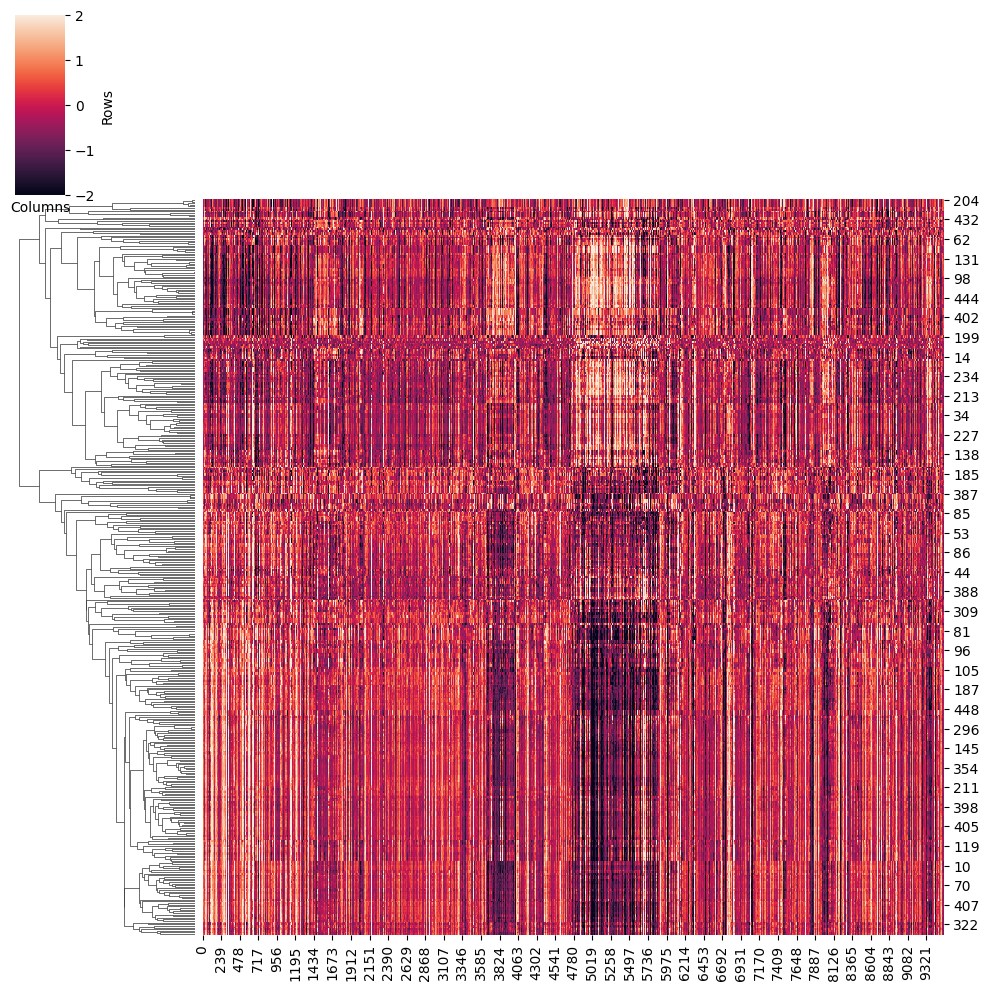

In [83]:
save=True
heatmap_cluster(TF_activity,adata_RNA,save,outdir)

### 9.1 Identify driver regulator

In [84]:
celltype = 'naive CD4 T cells'

In [85]:
t_test_results=master_regulator(TF_activity,adata_RNA,celltype)
t_test_results

,t_stat,p_value,adj_p
CLOCK,2.851817,2.178178e-03,3.533662e-03
BHLHE40,7.660409,1.016933e-14,1.887395e-14
NFIA,16.230465,9.281843e-59,4.025107e-58
TCF7,14.681442,1.422037e-48,4.275592e-48
MXD1,15.368317,5.692732e-53,2.037637e-52
...,...,...,...
FOXD2,4.624959,1.898010e-06,3.206003e-06
MYC,8.504323,1.050667e-17,2.051303e-17
RARB,18.923049,9.950818e-79,8.975638e-78
TEF,-15.844610,1.000000e+00,1.000000e+00


In [89]:
import inspect
print(inspect.signature(
    LL_net.cell_type_specific_TF_RE_binding_score_scNN
))

(mat, TFbinding, RE, TG, TFoverlap)


In [91]:
regulon_score, TFbinding, RE, TG, TFoverlap = \
    LL_net.cell_type_specific_TF_RE_binding_score_scNN(
        adata_RNA,
        adata_ATAC,
        celltype,
        GRNdir,   # path to previous results
        method    # "scNN" or whatever the method is
    )

AttributeError: 'str' object has no attribute 'loc'

In [86]:
TFName='CLOCK'
datatype='activity'
celltype1='naive CD4 T cells'
celltype2='Others'
save=True
box_comp(TFName,adata_RNA,celltype1,celltype2,datatype,regulon_score,save,outdir)

NameError: name 'regulon_score' is not defined

In [87]:
datatype='expression'
box_comp(TFName,adata_RNA,celltype1,celltype2,datatype,regulon_score,save,outdir)

NameError: name 'regulon_score' is not defined